In [1]:
# In this notebook we explain and compare the performance of the frequency localized and time localized inference algorithms, providing with formulas
# the experiments/error_comparison.py script

import numpy as np
from signals import  generate_frequency_localized_samples, generate_time_localized_samples
from sampling import  power_law_samples_symmetric
from fourier import compute_fourier_coeff, compute_inverse_fourier_coeff, get_fourier_coeffs
from kernels import  periodic_sobolev
from inference_utils import  compute_prediction, compute_error
from plotting import  plot_compare_approximations

import matplotlib.pyplot as plt

In [2]:
seed = 42  # or any integer of choice
rng = np.random.default_rng(seed)

#### A priori assumptions and space/frequency localization.

- $ G = \mathbb{R}/\mathbb{Z} = [0,1] $
- $  \widehat{K} \simeq \frac{1}{|\ell|^2} $ so that $ \mathcal{H} = H^1 $ 
- $  w_* \in H^2 $  so that 
  $$
  \sum_{\xi \in \mathbb{Z}} \left| (\mathcal{F} w_*)_\ell \right|^2 \ell^4 < +\infty
  $$
- $\sigma_\ell = \widehat{K}_\ell\, \mathbb{E}[ \left| (\mathcal{F} X)_\ell \right|^2 ] $
  
so that the source conditions can be written as
$$
\sum_{\ell\in\mathbb{Z}} \frac{\left| (\mathcal{F} w_*)_\ell \right|^2 \ell^2}{\sigma_\ell^{2r}} < +\infty.
$$



In [3]:
# Number of input functions
num_samples = 150

grid_size = 2**11 # grid points

t_left = 0
t_right = 1   # time interval

time_span = t_right - t_left

time_array = np.linspace(t_left,t_right,grid_size)
noise = .01 # noise level in the data


## Target function

W construct the target function fixing its Fourier coefficients decay rate 
$$
\hat{w}^\ast \sim \frac{1}{l^\beta},
$$ 
with decay rate $\beta$.
Since

$$
  \sum_{\ell \in \mathbb{Z}} \left| (\mathcal{F} w_*)_\ell \right|^2 \ell^4 < +\infty = C \sum_{\ell \in \mathbb{Z}} \frac{1}{|\ell|^{2\beta}} \ell^4 
=  C \sum_{\ell \in \mathbb{Z}} \frac{1}{\ell^{2\beta-4}}   < +\infty,
  $$

we choose $2\beta-4 > 1$ so $\beta > 2.5$.

Note: alternative, construct in time space with `construct_even_fourier_signal` or `construct_sine_series_signal`

In [4]:
# Ground truth function (target) and observation  noise         

# y_i = x_i * target + noise, where x_i is the input signal

#parameter for target signal
target_decay = 2.51  # decay rate of the target signal  ~ 1/target_decay

target_coeff= get_fourier_coeffs(target_decay, time_span, grid_size, c0=1, scale=1)
target = np.fft.ifft(target_coeff*grid_size).real


##Alternative target signal, constructed in the time domain
# from signals import construct_sine_series_signal
# target = construct_sine_series_signal(time_array, target_decay, 50)
# target_coeff = compute_fourier_coeff(target, time_span)

/home/emilia/.local/miniconda3/envs/conv/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/emilia/.local/miniconda3/envs/conv/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


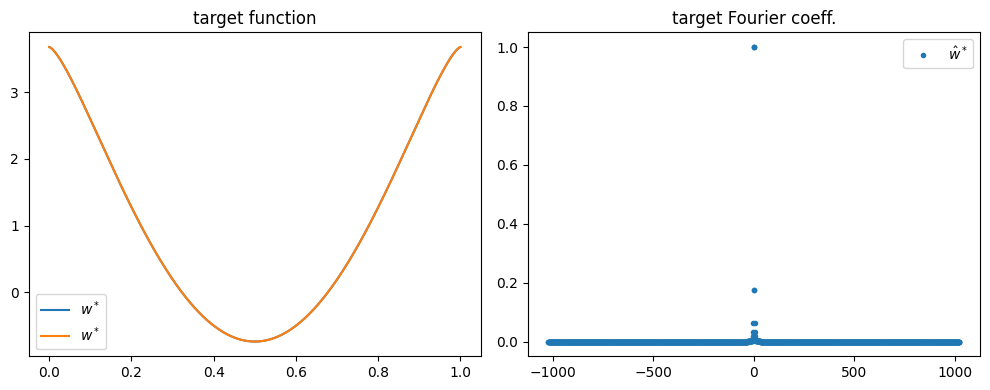

In [5]:
#Visualise target signal
fig,(ax1, ax2)  = plt.subplots(1,2,figsize=(10, 4))
ax1.plot(time_array, compute_inverse_fourier_coeff(target_coeff,time_span), label=r'$w^*$')
ax1.plot(time_array, target, label=r'$w^*$')
ax1.set_title('target function')
ax1.legend()


# Get the frequency bins. These tell us which Fourier mode (l) corresponds to each index.
freqs = np.fft.fftfreq(grid_size, time_span / grid_size)
ax2.plot(freqs,target_coeff, '.', label='$\hat{w}^*$')
ax2.set_title('target Fourier coeff.')
ax2.legend()
plt.tight_layout()

## Kernel
### Periodic Sobolev  kernel  

with $\hat{K} \simeq 1/{|l|}^2$, so that $\mathcal{H}   = H^1$
$$
K(t)=3t^2-3t+1 \quad t\in [0,1] , 
$$
with Fourier coefficients:

$$
\hat{K}_\ell= 
	\begin{cases}
	\frac{3}{2\pi^2}  \frac{1}{\ell^2} & \ell\neq 0 \\
         \frac{1}{2}     & \ell=0
	\end{cases}
$$

We construct the Sobolev kernel starting from the Fourier coefficients $\hat{K}_\ell$ (and the inverse Fourier transform to visualise in time space).

In [6]:
# we construct the kernel coefficients with decay rate 2

kernel_decay =  2 # decay rate of the  complex exponential kernel   #1.01
kernel_coeff = get_fourier_coeffs(kernel_decay, time_span, grid_size, c0=1/2, scale=3/(2*np.pi**2))


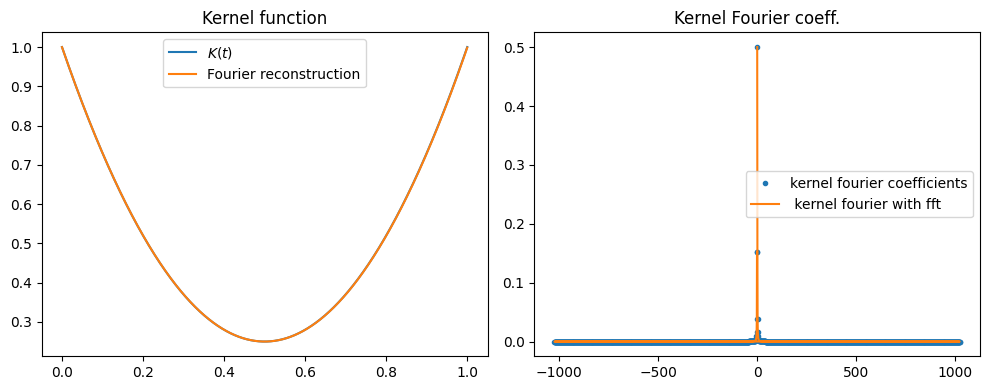

In [7]:
# visualize the kernel's fourier coefficients decay  (for the complex exponential kernel)

fig,(ax1, ax2)  = plt.subplots(1,2,figsize=(10, 4))
ax1.plot(time_array, periodic_sobolev(time_array), label=r'$K(t)$')
ax1.set_title('Kernel function')
ax1.plot(time_array, np.fft.ifft(kernel_coeff*grid_size), label='Fourier reconstruction')
ax1.legend()


# Get the frequency bins. These tell us which Fourier mode (l) corresponds to each index.
freqs = np.fft.fftfreq(grid_size, time_span / grid_size)
ax2.plot(freqs,kernel_coeff, '.', label='kernel fourier coefficients')
ax2.plot(freqs,(compute_fourier_coeff(periodic_sobolev(time_array),time_span)), label=' kernel fourier with fft')   #shouldn't they be real??
ax2.set_title('Kernel Fourier coeff.')
ax2.legend()
plt.tight_layout()

## 1. Frequency-Localized Inputs

Random frequencies are drawn from a (symmetric) power-law distribution and then each sample is generated as a complex exponential evaluated at the points in the `time_array`.  
$$
\text{Summary:} \quad \boxed{X(t) = \left[ e^{2\pi i \ell_1 t}, \, e^{2\pi i \ell_2 t}, \, \dots, \, e^{2\pi i \ell_{n_{\text{samples}}} t} \right] \quad \text{with} 
\quad \ell_k \sim \text{PowerLaw}(\alpha, f_{\max}).}
$$

**Random frequency generation:** 
   Each _frequency_ $\ell_k$ is sampled according to a power-law distribution $p_\ell \propto |\ell|^{-\alpha} \quad \text{for } 0 < \ell \leq f_{\max}, \ \text{and} \ - f_{\max}< \ell < 0$. 
   $$
   \ell_1, \ell_2, \dots, \ell_{n_{\text{samples}}} \sim p_l =\text{PowerLaw}(\alpha, f_{\max}).
   $$
   where $\alpha$ is the exponent (provided as the `exponent` parameter) and $f_{\max}$ corresponds to `max_value`.

**Signal Generation:** For each frequency $\ell_k$ and for every time point $t$ in the `time_array`, the sample is computed as:
   $$
   X_k(t) = e^{2\pi i \ell_k t}.
   $$
   Thus, the entire sample matrix $X$ (with dimensions corresponding to the number of time points by the number of samples) is given by:
   $
   X(t) = \begin{bmatrix}
   e^{2\pi i \ell_1 t} & e^{2\pi i \ell_2 t} & \cdots & e^{2\pi i \ell_{n_{\text{nsamples}}} t}
   \end{bmatrix}.
   $


### Source conditions
With these $X_k$, then 
$$ 
\sigma_\ell \simeq |\ell|^{-2} p_\ell  \to
|\ell|^{-3} \quad p_\ell \to \ell^{-1} . \quad \quad \text{So} \quad b=3, r=\frac{1}{3}.
$$

- Decay rate parameter for freq-loc inputs: $\alpha = 1$
- Maximum frequency for power law samples: $f_{max} = M$
- Regularization parameter: $b = 3$




In [8]:
# freq-loc input signals 
freq_loc_inputs_decay = 1 
freq_max = grid_size // 2

r_freq_loc = 1 / 3
b_freq_loc = 3

X_freq_loc = generate_frequency_localized_samples(num_samples, time_array, freq_max, freq_loc_inputs_decay, power_law_samples_symmetric, seed=seed)

In [9]:
# run inference for freq-localized signals
prediction_four_coeff_freq_loc, prediction_freq_loc = compute_prediction(
    num_samples=num_samples,
    time_array=time_array,
    time_span=time_span,
    kernel_coeff=kernel_coeff,
    target_coeff=target_coeff,
    noise=noise,
    r=r_freq_loc,
    b = b_freq_loc,
    const = 1e-4,
    X = X_freq_loc,
)

Note: we compute the approximation $w_n^\lambda$ via its Fourier coefficients:
$$
 (\mathcal{F}{w}_n^\lambda)_\xi=
    \frac{\frac{\hat{K}_\xi}{n}\sum_{i=1}^n (\mathcal{F} Y_i)_\xi \overline{(\mathcal{F}
        X_i)_\xi} }{\frac{\hat{K}_\xi}{n}\sum_{i=1}^n |(\mathcal{F} X_i)_\xi|^2+ \lambda
      } \quad  \xi\in \hat{G}_* 
$$

## 2. Space-Localized Inputs
Random localization centers are drawn from a distribution on  $G=[0,1]$, and then each sample is generated as a time-localized indicator function (or "window") around the chosen center.  

We consider the signals 
$$      
 X(t) =
 \begin{cases}
   \frac{1}{2\delta} &   \tau-\delta\leq  t \leq \tau+\delta \\
     0 & \text{otherwise}
 \end{cases}
$$

with $\tau$ a random variable taking values in $G=[0,1]$ and $\delta \in \mathbb{R}^+$ is small.

We generate these signals via `generate_time_localized_samples`. 

First, we genrate $n_\text{samples}$ random variables
     $$
     \tau_1, \tau_2, \dots, \tau_{n_{\text{samples}}} \sim \mathcal{N}(\mu, \sigma^2). \quad \mu =0.5,\  \sigma = 0.16
     $$
  
Second, we then generate the signals 
$$
X_k(t) = \frac{1}{2\delta} \cdot \mathbf{1}_{\{|t-\tau_k | \le \delta\}},
$$
where $\mathbf{1}_{\{|t-\tau| \le \delta\}}$ is the indicator function that is $1$ if $|t-\tau | \le \delta$ and $0$ otherwise.

### Source conditions
With these $X_k$, then 
$$ 
\sigma_\ell \simeq \hat{K}_\ell \ \text{sinc}^2(2\pi \delta \ell) \simeq |\ell|^{-2}
    \text{sinc}^2(2\pi\delta\ell)\  \operatornamewithlimits{\longrightarrow}_{\delta\to 0} \ |\ell|^{-2} . \quad \text{So} \quad b=2, \ r=\frac{1}{2}.
$$

- Localization parameter $\delta$ for space-loc inputs: $\delta = .001$
- Regularization parameter: $b = 2$


In [10]:
#time-loc inputsignals 
loc_parameter = 0.001
r_time_loc = 1 / 2
b_time_loc = 2

X_time_loc = generate_time_localized_samples(num_samples, time_array, loc_parameter,seed=seed+1)


In [11]:
# run inference for time-localized signals
prediction_four_coeff_time_loc, prediction_time_loc = compute_prediction(
    num_samples=num_samples,
    time_array=time_array,
    time_span=time_span,
    kernel_coeff=kernel_coeff,
    target_coeff=target_coeff,
    noise=noise,
    r=r_time_loc,
    b = b_time_loc,
    const = 1e-4,
    X= X_time_loc
)

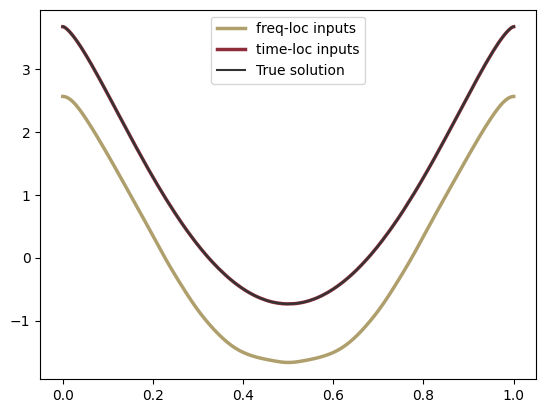

In [12]:
plot_compare_approximations(time_array = time_array, target=target, prediction_freq_loc=prediction_freq_loc, prediction_time_loc=prediction_time_loc)

## Error computation

### Approxmation error $||w_n^\lambda-w_*||^2_\mathcal{H}$

In the error comparison between the settings of the two types of inputs, we analyze the $\mathcal{H}$-error decay as a function of the sample size $n$, by computing the quantity: 

$$
||w_n^\lambda-w_*||^2_\mathcal{H} 
$$

where, as explained above, $w_n^\lambda$ is computed via its Fourier coefficients formula., and the norm in $\mathcal{H}$ is given by 

$
 ||w||^2_\mathcal{H} = \sum_{\xi\in \hat{G}}  \dfrac{(\mathcal{F} w)_{\xi}
  \overline{(\mathcal{F} w)_{\xi} }}{\hat{K}_{\xi} } = \sum_{\xi\in \hat{G}}  \dfrac{|(\mathcal{F} w)_{\xi}|^2
   }{\hat{K}_{\xi} } . $

We can compute the error for the two types of inputs and compare the decay rate:
$$
||w_n^\lambda-w_*||^2_\mathcal{H} \lesssim 
 n^{-\frac{2r}{2r+1+b^{-1}}},
$$




### Operator error $||\Sigma^{\frac{1}{2}}(w_n^\lambda-w_*)||^2_\mathcal{H}$

To compute this we will need the eigenvalues $\sigma_\ell = \hat{K}_\ell\, \mathbb{E}[ \left| (\mathcal{F} X)_\ell \right|^2 ]$ of the covariance operator $\Sigma$.

The squared norm becomes 
$$
||\Sigma^{\frac{1}{2}}(w_n^\lambda-w_*)||^2_\mathcal{H}  = \sum_{\xi\in \hat{G}}  \dfrac{\sigma_\xi|(\mathcal{F} w^\lambda_n)_{\xi}-(\mathcal{F} w^\star)_{\xi}|^2
   }{\hat{K}_{\xi} } \lesssim 
 n^{-\frac{2r+1}{2r+1+b^{-1}}} .
$$

In [13]:
num_experiments = 5  # number of experiments to run for each sample size
const = 1e-1 # constant for the regularization term lambda

In [14]:
# error computation for frequency localised signals

sample_gen_params_freq_loc = {
    "max_value": freq_max,
    "exponent": freq_loc_inputs_decay,
    "power_law_func": power_law_samples_symmetric,
    "seed": rng,   ## to get error bars you need rng.. not seed!
}

error_squared_sampmean_freq_loc, error_squared_sampstd_freq_loc = compute_error(
    num_samples,
    num_experiments,
    time_array,
    time_span,
    kernel_coeff,
    target_coeff,
    noise,
    r_freq_loc,
    b_freq_loc,
    const,
    generate_frequency_localized_samples,
    sample_gen_params_freq_loc,
)

/home/emilia/Projects/CONVOLUTION/learnconv/src/inference_utils.py:179: ComplexWarning: Casting complex values to real discards the imaginary part
  errors[j] = error     #it's the SQUARED mean squared error


In [15]:
## error computation for time localised signals

sample_gen_params_time_loc = {
    "delta": loc_parameter,
    "seed": rng,
}

error_squared_sampmean_time_loc, error_squared_sampstd_time_loc = compute_error(
    num_samples,
    num_experiments,
    time_array,
    time_span,
    kernel_coeff,
    target_coeff,
    noise,
    r_time_loc,
    b_time_loc,
    const,
    generate_time_localized_samples,
    sample_gen_params_time_loc,
)

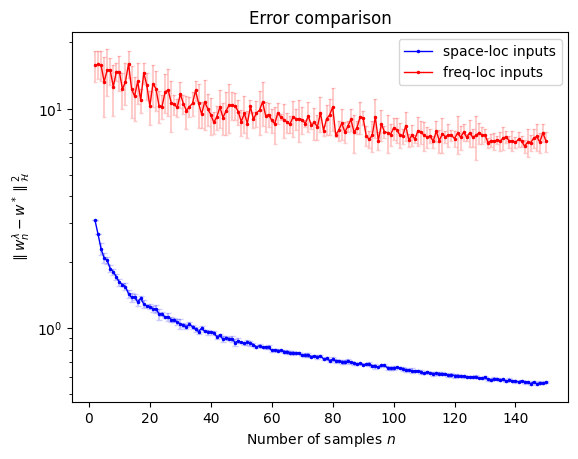

In [16]:
#plot the errors
# #error time-loc inputs

fig, ax = plt.subplots(1,  )

index = np.arange(1,error_squared_sampmean_time_loc.size+1)


#time-loc
ax.errorbar(index[1:], error_squared_sampmean_time_loc[1:], yerr =error_squared_sampstd_time_loc[1:], color='b', fmt='.', alpha=.2,capsize=2.5,ms=1)
ax.plot(index[1:], error_squared_sampmean_time_loc[1:], 'o-', markersize=1.5, color='b', alpha =1, lw=1, label=r'space-loc inputs')


#frequency-loc
ax.errorbar(index[1:], error_squared_sampmean_freq_loc[1:], yerr =error_squared_sampstd_freq_loc[1:], color='r', fmt='.', alpha=.2, capsize=1.5,ms=1)
ax.plot(index[1:], error_squared_sampmean_freq_loc[1:], 'o-', markersize=1.5, color='r', alpha =1.,lw =1,label=r'freq-loc inputs')

#################################
ax.set_xlabel(r'Number of samples $n$')
ax.set_ylabel(r'$ \parallel {w}^\lambda_n - w^* \parallel_{\mathcal{H}} ^2$')
# ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title(r'Error comparison')

ax.legend()
# plt.savefig('Error-comparison_no-rate.pdf', bbox_inches='tight')


In [17]:
# #compute error for both approximations



# error_squared_sampmean_time_loc, error_squared_sampstd_time_loc = compute_error_time_loc(
#     num_samples=num_samples,
#     num_experiments= 5,
#     time_array=time_array,
#     time_span=time_span,
#     kernel_coeff= kernel_coeff,
#     target_coeff=target_coeff,
#     noise=noise,
#     r=r_time_loc,
#     b = b_time_loc,
#     const=1e-1,
#     loc_parameter = loc_parameter,
# )

# #compute error for freq-loc input signals
# error_squared_sampmean_freq_loc, error_squared_sampstd_freq_loc = compute_error_freq_loc(
#     num_samples=num_samples,
#     num_experiments= 5,
#     time_array=time_array,
#     time_span=time_span,
#     kernel_coeff= kernel_coeff,
#     target_coeff=target_coeff,   ### WHY ABS bEFORE!!!!!!!!!
#     noise=noise, 
#     r=r_freq_loc,
#     b = b_freq_loc,
#     const = 1e-1,
#     freq_loc_inputs_decay=freq_loc_inputs_decay,
#     freq_loc_max=freq_max
# )